In [1]:
import sys
print(sys.version)

import pickle
import pandas as pd
from utils import *
from sklearn.decomposition import PCA
from sklearn import linear_model, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, Matern
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import random
random.seed(4487)

3.11.8 | packaged by Anaconda, Inc. | (main, Feb 26 2024, 21:34:05) [MSC v.1916 64 bit (AMD64)]


In [2]:
with open('data.pkl', 'rb') as file:
    # 使用pickle的load方法从文件反序列化数据
        data_loaded = pickle.load(file)
# data_loaded现在是一个包含x，y，label的字典
x = data_loaded['x']
y = data_loaded['y']
label = data_loaded['label']
trainX, trainY, testX, testY = train_test_split(x, y)

In [3]:
## Basic methods - KNN GCP LR
def KNN(trainX, trainY, testX):
    param_grid = {
        'pca__n_components': [11], # Number of components for PCA
        'knn__n_neighbors': [i for i in range(2, 30)],
        'knn__weights': ['distance', 'uniform'],
        'knn__p': [1, 2]
    }

    # Create a pipeline with PCA and KNeighborsClassifier
    pipeline = Pipeline([
        ('pca', PCA()),
        ('knn', KNeighborsClassifier())
    ])

    # Use GridSearchCV to find the best parameters
    knn = GridSearchCV(pipeline, param_grid, cv=10)
    knn.fit(trainX, trainY)

    print("knn best parameters: ", knn.best_params_)
    pred = knn.predict(testX)
    prob = knn.predict_proba(testX)[:, 1]
    return pred, prob

def GPC(trainX, trainY, testX):
    kernel_options = [1.0 * RBF(length_scale=10), 1.0 * Matern(length_scale=10)]
    param_grid = {
        'pca__n_components': [11], # Number of components for PCA
        'gpc__kernel': kernel_options,
        'gpc__n_restarts_optimizer': [0, 1, 2]
    }

    # Create a pipeline with PCA and GaussianProcessClassifier
    pipeline = Pipeline([
        ('pca', PCA()),
        ('gpc', GaussianProcessClassifier(random_state=4487))
    ])

    # Use GridSearchCV to find the best parameters
    gpc = GridSearchCV(pipeline, param_grid, cv=10)
    gpc.fit(trainX, trainY)

    print("GPC best parameters: ", gpc.best_params_)
    pred = gpc.predict(testX)
    prob = gpc.predict_proba(testX)[:, 1]
    return pred, prob


def LR(trainX, trainY, testX):
    # Standardize the data
    scaler = StandardScaler()
    trainX_scaled = scaler.fit_transform(trainX)
    testX_scaled = scaler.transform(testX)

    # Apply PCA
    pca = PCA(n_components=11) # Choose the number of components
    trainX_pca = pca.fit_transform(trainX_scaled)
    testX_pca = pca.transform(testX_scaled)

    lr = linear_model.LogisticRegressionCV(
        Cs=logspace(-4, 4, 20), 
        cv=10, 
        max_iter=10000, 
        multi_class='multinomial', 
        scoring='accuracy',
    )
    lr.fit(trainX_pca, trainY)

    prob = lr.predict_proba(testX_pca)[:, 1]
    pred = lr.predict(testX_pca)

    return pred, prob

# Logistic Regression

0.84251968503937
ROC_AUC : 0.9202898550724637


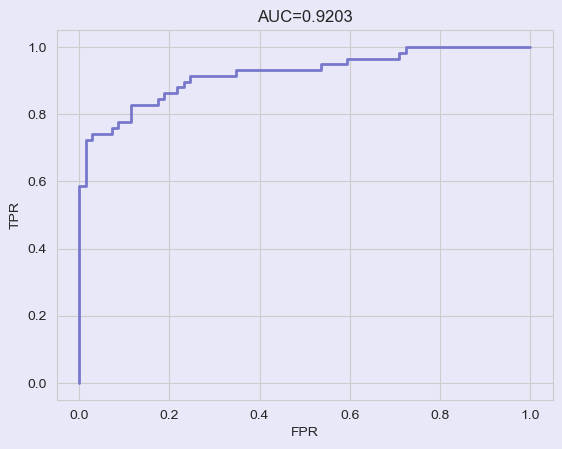

In [4]:
lr_pred, lr_prob = LR(trainX, trainY, testX)
acc = metrics.accuracy_score(testY, lr_pred)  # 超低
print(acc)
plot_roc(testY, lr_prob)

## KNN

knn best parameters:  {'knn__n_neighbors': 8, 'knn__p': 2, 'knn__weights': 'distance', 'pca__n_components': 11}
0.8110236220472441
ROC_AUC : 0.8930534732633684


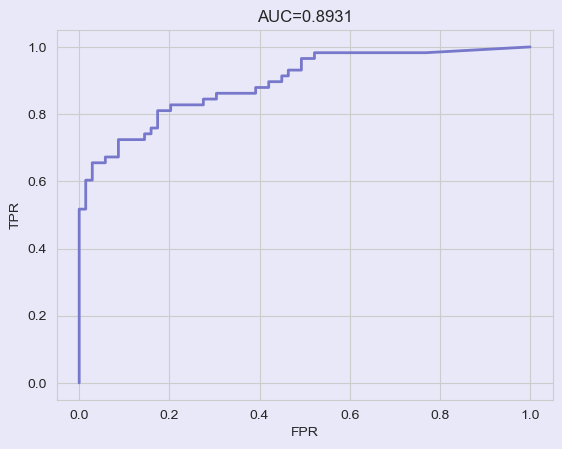

In [5]:
knn_pred, knn_prob = KNN(trainX, trainY, testX)
acc = metrics.accuracy_score(testY, knn_pred)
print(acc)
plot_roc(testY, knn_prob)

# GPC

GPC best parameters:  {'gpc__kernel': 1**2 * Matern(length_scale=10, nu=1.5), 'gpc__n_restarts_optimizer': 0, 'pca__n_components': 11}
0.8503937007874016
ROC_AUC : 0.9090454772613693


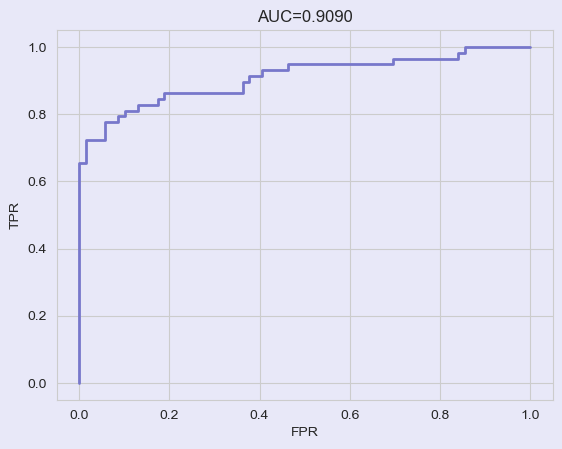

In [6]:
gpc_pred, gpc_prob = GPC(trainX, trainY, testX)
acc = metrics.accuracy_score(testY, gpc_pred)
print(acc)
plot_roc(testY, gpc_prob)

## Ensemble Methods

In [7]:
def RF(trainX, trainY, testX):
    
    param_grid = {
        'pca__n_components': [11], # Number of components for PCA
        'rf__n_estimators': [500, 600, 800]
    }
    
    # Create a pipeline with PCA and RandomForestClassifier
    pipeline = Pipeline([
        ('pca', PCA()),
        ('rf', RandomForestClassifier(random_state=4487))
    ])

    # Use GridSearchCV to find the best parameters
    rf = GridSearchCV(pipeline, param_grid, cv=10)
    rf.fit(trainX, trainY)

    print("RF Parameter:", rf.best_params_)

    pred = rf.predict(testX)
    prob = rf.predict_proba(testX)[:, 1]
    return pred, prob


def XGBoost(trainX, trainY, testX):
    
    param_grid = {
        'pca__n_components': [11],
        'xgb__learning_rate': logspace(-3, 3, 20),
        'xgb__n_estimators': array([500, 1000])
    }
    # print(paramgrid)

    # Create a pipeline with PCA and XGBoostClassifier
    pipeline = Pipeline([
        ('pca', PCA()),
        ('xgb', XGBClassifier(eval_metric='logloss', random_state=4487))
    ])

    # Use GridSearchCV to find the best parameters
    xgb = GridSearchCV(pipeline, param_grid, cv=10, n_jobs=-1)
    xgb.fit(trainX, trainY)
    print("best params:", xgb.best_params_)

    pred = xgb.predict(testX)
    prob = xgb.predict_proba(testX)[:, 1]

    return pred, prob

RF Parameter: {'pca__n_components': 11, 'rf__n_estimators': 800}
0.84251968503937
ROC_AUC : 0.8930534732633683


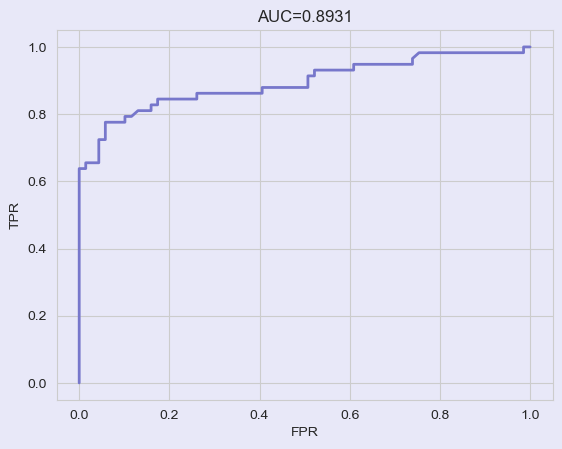

In [8]:
RF_pred, RF_prob = RF(trainX, trainY, testX)
acc = metrics.accuracy_score(testY, RF_pred)
print(acc)
plot_roc(testY, RF_prob)

best params: {'pca__n_components': 11, 'xgb__learning_rate': 0.0379269019073225, 'xgb__n_estimators': 500}
0.84251968503937
ROC_AUC : 0.8840579710144928


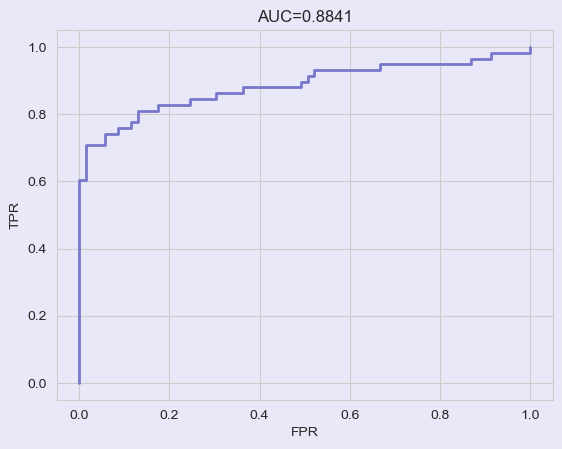

In [9]:
xgb_pred, xgb_prob = XGBoost(trainX, trainY, testX)
acc = metrics.accuracy_score(testY, xgb_pred)
print(acc)
plot_roc(testY, xgb_prob)